In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Load the data

In [2]:
stops = gpd.read_file("metlink-stops.gpkg").to_crs(2193)[
    ["stop_code", "stop_name", "geometry"]]
routes = gpd.read_file("metlink-routes.gpkg").to_crs(2193)[
    ["route_id", "route_type", "route_short_name", "geometry"]]
sa2 = gpd.read_file("sa2-wellington.gpkg")

# Binary GIS operations
Whenever possible, I recommend performing joins, filtering data, querying data, etc. without using spatial characteristics. It's just quicker. This holds whether you are using a GIS or using Python. The speed of tabular operations based on non-spatial data is one reason discrete global grid systems such as H3 are gaining in popularity.

Anyway... regardless there are many situations where you do want to deploy spatial methods which we quickly explore in this notebook.

## The spatial predicate methods
'Spatial predicates' is a fancy word for 'tests for spatial relations'. These are things like 'intersects', 'contains' and so on. A full list of the predicates available as methods is available in the documentation [here](https://geopandas.org/en/stable/docs/reference/geoseries.html#binary-predicates).

But, I'll be honest... the binary spatial predicate operations in `geopandas` are _weird_. They work fine, but they work _row-wise_. This means that when you do something like (say)

```python
sa2.intersects(routes)
```

what is being done is a row-by-row test if the first polygon in the `sa2` table intersects the first route in the `routes` table, and so on. As illustrated in the `geopandas` documentation, it does this:



There are options you can set to make the one-to-one comparison based on the respective dataframe indexes, but either way it's hard to think of a situation where this one-to-one behaviour is useful! Generally, what you want to do is check for spatial relationships between every possible pair of geometries in the two dataframes, so that you can identify which pairs of elements from the two datasets are related to one another. 

To illustrate this, take the simple example of applying a _spatial filter_. It is a common requirement to filter a dataset (say the bus routes) to only those that pass overlap or intersect, or otherwise spatially relate to at least one of the SA2s in our Wellington dataset.  Using the `intersects()` method as a boolean selector without thinking too hard about it we get

/var/folders/xn/1pzc3z9j5vz8l0mv67t5tygw0000gn/T/ipykernel_1336/2712182889.py:3: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  routes[routes.intersects(sa2)].plot(ax = ax, ec = "red")
/Users/david/miniconda3/envs/intro-python-2/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


<Axes: >

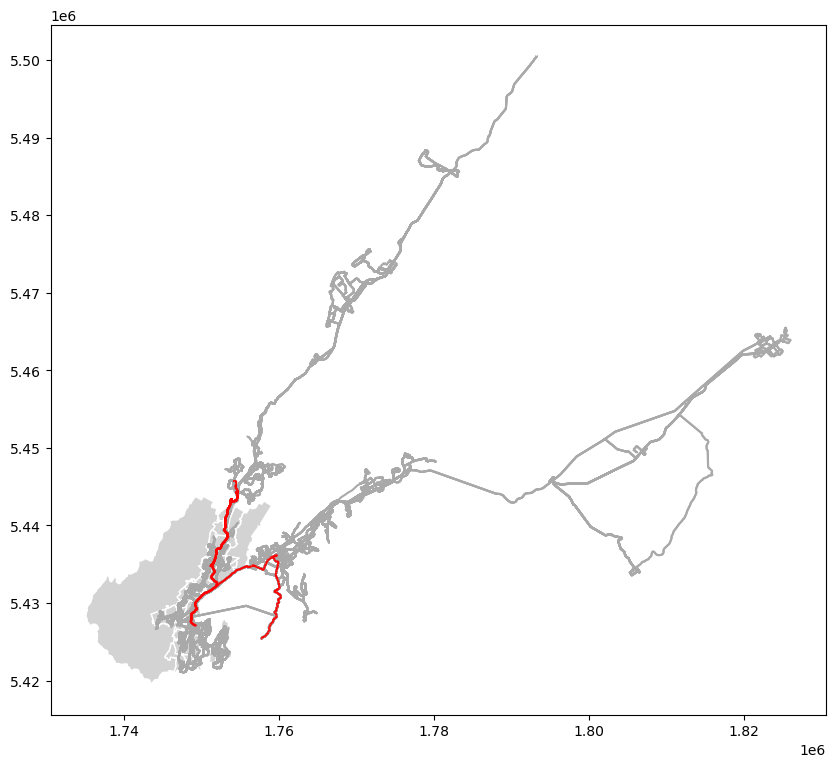

In [8]:
ax = sa2.plot(fc = "lightgrey", ec = "w", figsize = (10, 10))
routes.plot(ax = ax, ec = "darkgrey")
routes[routes.intersects(sa2)].plot(ax = ax, ec = "red")


That's almost certainly _not_ what we had in mind. To get the filtering behaviour I had in mind, I have apply `union_all()` to the SA2 data, like this:

/Users/david/miniconda3/envs/intro-python-2/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


<Axes: >

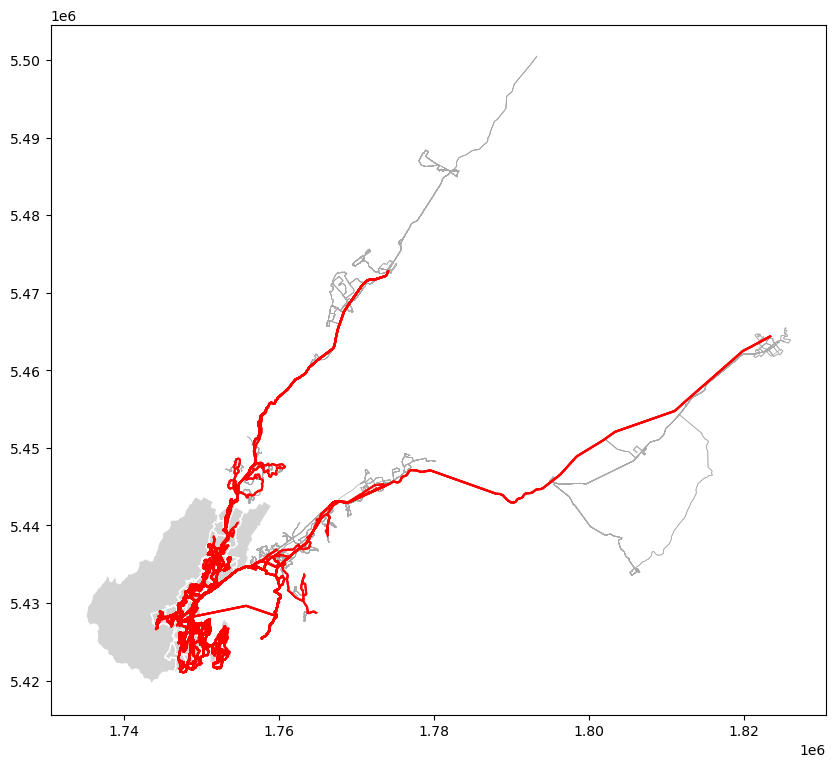

In [43]:
ax = sa2.plot(fc = "lightgrey", ec = "w", figsize = (10, 10))
routes.plot(ax = ax, ec = "darkgrey", lw = 0.5)
routes[routes.intersects(sa2.union_all())].plot(ax = ax, ec = "red")

OK... fine, it works. But here's a better way:

<Axes: >

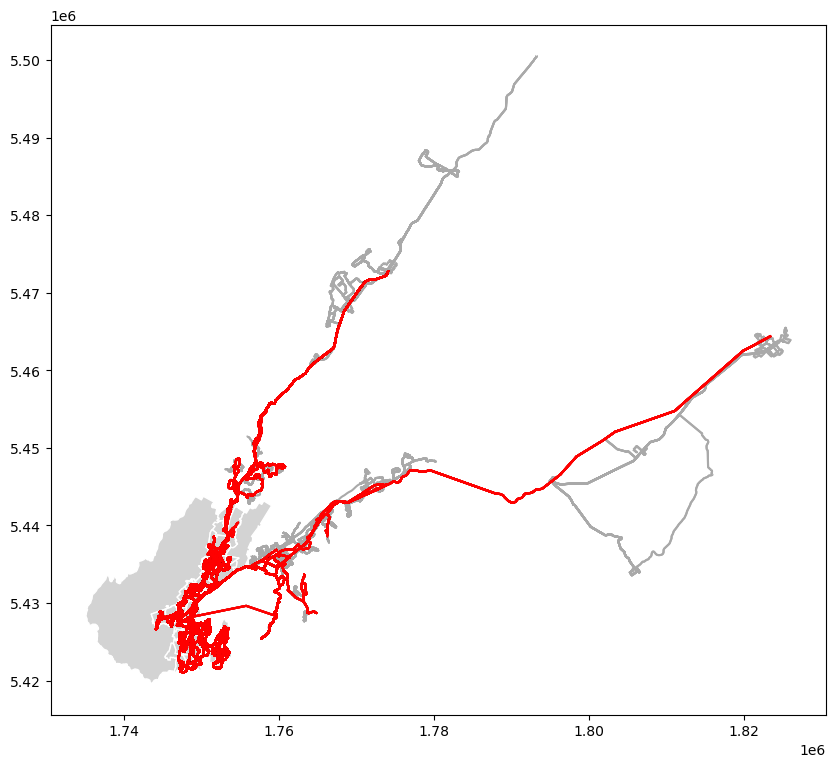

In [18]:
ax = sa2.plot(fc = "lightgrey", ec = "w", figsize = (10, 10))
routes.plot(ax = ax, ec = "darkgrey")
routes.sjoin(sa2[["geometry"]]).plot(ax = ax, ec = "red")

## Spatial filtering
It's often smart to filter data so that you are only working with data within some study area. A good example with our transport data is that perhaps we only care about routes and stops that fall inside the scope of the SA2 statistical data. A spatial filter is similar to the kind of filtering we apply in `pandas` using a boolean selection.

In [ ]:
routes_sa2 = routes[routes.intersects(sa2.union_all())]
m = sa2.explore(tooltip = False, tiles = "CartoDB dark_matter")
routes.explore(m = m, style_kwds = {"color": "pink"})
routes_sa2.explore(m = m, style_kwds = {"color": "red"})

Combining filters can be fiddly because you have to make sure the order of application of the boolean logic is correct usually with lots of parentheses. Remember to use `&` and `|` here for the logical and/or operations. Below I select only bus routes (`route_type == "3"`) that intersect the SA2s.

In [ ]:
routes_buses_sa2 = routes[(routes.intersects(sa2.union_all())) &
                          (routes.route_type == "3")]
routes_buses_sa2.explore()

One important wrinkle here is that I have to use `sa2.union_all()` for the intersection test. That's because simply testing for intersection with the `sa2` `GeoDataFrame` gives us something quite different. It matches elements in each `GeoSeries` one-to-one in order testing for the intersection of each pair and retaining only those geometries that intersect the corresponding element in the other set of geometries. It's hard to imagine a situation where that is what you would want!

In [ ]:
routes[routes.intersects(sa2.geometry)].explore()

A number of other _spatial predicates_ are supported in the same row-wise way: `disjoint()`, `touches()`, `crosses()`, `within()`, `covers()`, `covered_by()`, `dwithin()`, `contains()`, `contains_properly()`. They are [documented here](https://geopandas.org/en/stable/docs/reference/geoseries.html#binary-predicates).

This behaviour means that doing the much more common operation of selecting all the geometries in one layer that intersect _any_ geometry in another layer requires the `union_all()` operation applied above. This is one reason that you may find it useful to use some of the representative shapes noted in the previous notebook. The `union_all()` operation can be computationally costly, and it may be quicker in some cases to apply it not to the raw data but to the _envelopes_ of the data, which should make the unioning operation that combines all the polygons quicker.

In [ ]:
routes[(routes.geometry.intersects(sa2.envelope.union_all())) &
       (routes.route_type == "3")].explore()

Now that we have a reduced set of routes, we can do a similar filter on the stops so that only those within some distance of one of the selected routes are retained. For this we change the `predicate` of the boolean selection.

In [ ]:
stops_buses_sa2 = \
    stops[stops.geometry.dwithin(routes_buses_sa2.union_all(), 10)]

In [ ]:
m = routes_buses_sa2.explore(style_kwds = {"color": "black"}, tooltip = False)
stops_buses_sa2.explore(m = m, style_kwds = {"color": "red"}, tooltip = False)


## Clipping
An alternative to spatial filtering may be _clipping_ a layer to the extent of another layer. This is straightforward, and will automatically clip to the total bounds of the clipping layer. This is generally most useful for mapping purposes, when you want to restrict all the layers in a map to match the extent of one of the layers. In such situations this is often preferable to restricting the plot limits using `ax.set_xlim(...)` and `ax.set_ylim(...)`.

In [ ]:
routes.clip(sa2).explore()

## Spatial join
As we saw in `pandas` a fundamental analysis operation is reorganising data by joining tables based on matching values in data columns. The same operation is available when the relation between the columns is a spatial one, provided both datasets have associated geometry, and provided that they are in matching projections. Because a spatial join is always based on a geometric relationship you don't have to supply any information about the columns to use (it will always use the geometry columns). 

The join is assumed to be `how = "inner"` so only combinations of geometries for which the relationship exists will be returned. Often you will want to retain all the records in the 'left' data table and should specify `how = "left"` instead. 

You can also specify different spatial relations of interest using the `predicate` parameter. This defaults to `"intersects"` but you can select any of the predicates returned by `df.sindex.valid_query_predicates`.

So... let's first check which predicates are available.

In [ ]:
sa2.sindex.valid_query_predicates

Seems reasonable. From what I can tell it returns the same list for line and point layers, which seems a bit wrong, but let's carry on anyway.

Some relationships are one-to-one and relatively simple. For example, each bus stop can only be within one SA2.

In [ ]:
stops_buses_sa2.sjoin(sa2, how = "inner", predicate = "within")

The result of the join retains the geometry of the left hand dataset and attaches the data from the row in the right hand dataset with which it has the specified spatial relationship.

One-to-many relationships are more complicated. For example, each SA2 contains anything from 0 to many bus stops.

In [ ]:
sa2.sjoin(stops_buses_sa2, how = "left")
sa2_stops

We have an output table with 1272 entries. This is more than the numbers of SA2s (78) and also more than the number of stops (1268). The four 'extra' rows are four SA2s which contain no stops, which have been retained because we specified `how = "left"`. They appear in the table with NaN values in the columns from the stops dataset. An example is Tawa North as seen in the results.

With a one-to-many relation like this we probably need to apply some additional processing so that the added columns contain meaningful data. In this case we might simply want to count the stops, in which case we can use the `groupby()` method we saw earlier today. Here's a recipe to get counts of the points in polygons as a simple table of counts of stops by named SA2.

In [ ]:
n_stops = sa2_stops \
    .groupby("name", as_index = False) \
    .count() \
    .loc[:, ["name", "sa2_code"]] \
    .rename(columns = {"sa2_code": "n"})
n_stops

Perhaps the strangest thing about spatial joins in `geopandas` is that this is the only way to persuade it to produce all the pairwise combinations between geometries in two datasets, even if you don't want to do a join of their attributes.


In [ ]:
sa2_stops \
    .dissolve(by = "name", aggfunc = {"stop_code": "count"}, as_index = False) \
    .rename(columns = {"stop_code": "n"})

In [ ]:
routes_buses_sa2